# GAT-Based Breast Cancer Classification

## 1. Import Libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import kneighbors_graph

## 2. Load Dataset

In [54]:
# Load the Breast Cancer dataset
df = pd.read_csv("breast-cancer.csv")
df.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [55]:
print(df.isnull().sum())  # Check for missing values

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [56]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## 3. Data Preprocessing

In [122]:
# Drop ID column and encode diagnosis
if "id" in df.columns:
    df = df.drop(columns=["id"])

le = LabelEncoder()
df["diagnosis"] = le.fit_transform(df["diagnosis"])  # M=1, B=0
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Removes the id column as it is not useful for the model.

Uses LabelEncoder to convert the target variable diagnosis into numerical values (Malignant = 1, Benign = 0).

## 4. Exploratory Data Analysis (EDA)

In [61]:
# Exploratory Data Analysis (EDA)
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int32  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se     

In [62]:
print("\nClass Distribution:")
print(df["diagnosis"].value_counts())



Class Distribution:
diagnosis
0    357
1    212
Name: count, dtype: int64


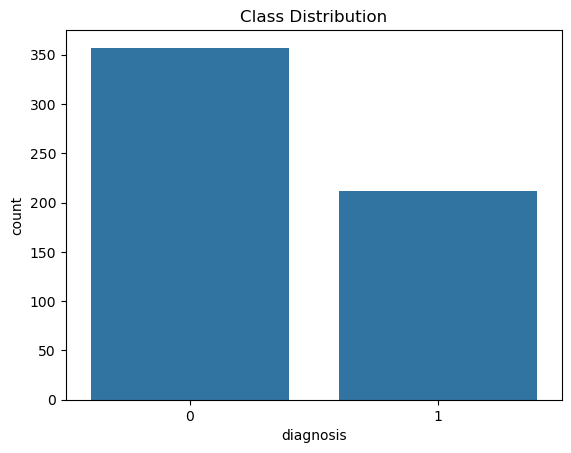

In [63]:
# Plot class distribution
sns.countplot(x=df["diagnosis"])
plt.title("Class Distribution")
plt.show()

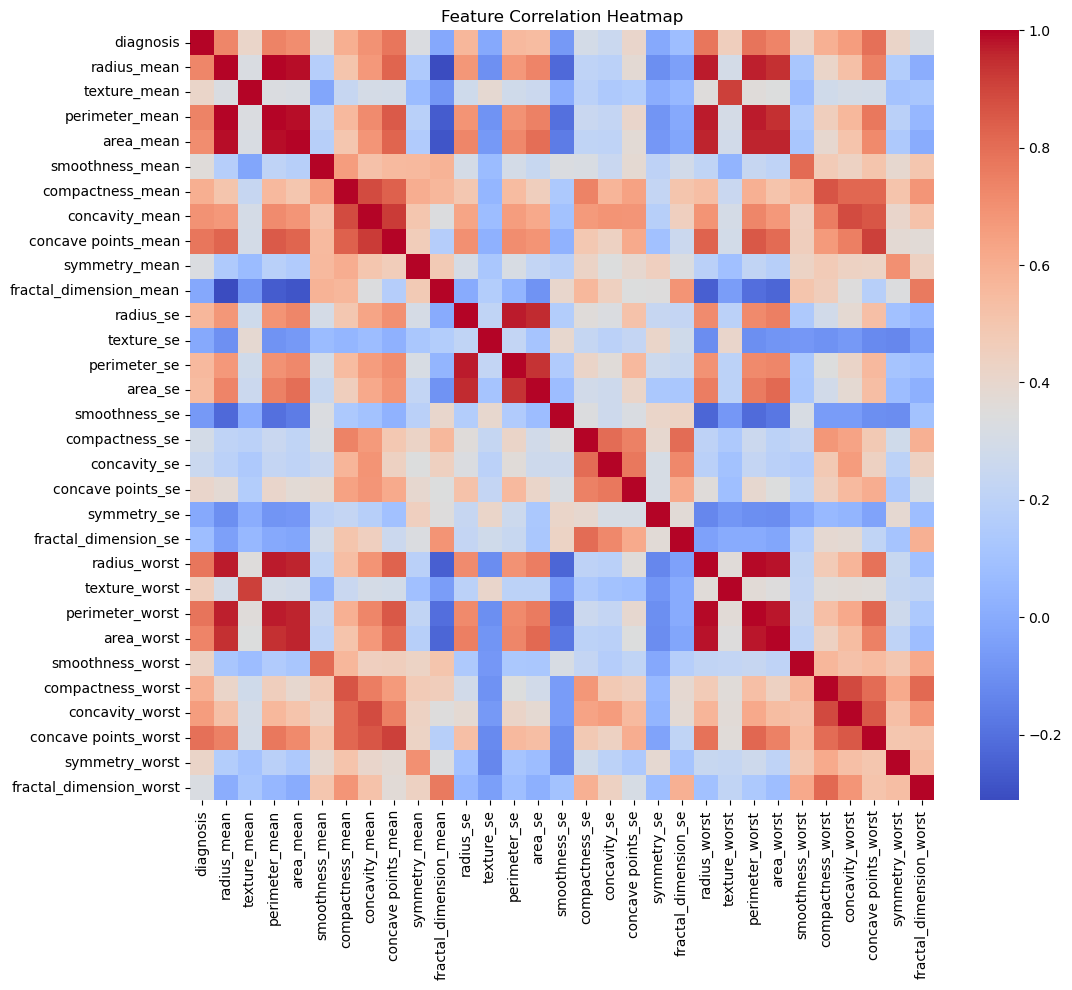

In [64]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [65]:
numeric_features = df.columns[df.columns != "diagnosis"]


C:\Users\oyede\AppData\Local\Temp\ipykernel_18840\1120737093.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="diagnosis", y=feature, data=df, palette="Set2")
C:\Users\oyede\AppData\Local\Temp\ipykernel_18840\1120737093.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="diagnosis", y=feature, data=df, palette="Set2")
C:\Users\oyede\AppData\Local\Temp\ipykernel_18840\1120737093.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="diagnosis", y=feature, data=df, palette="Set2")
C:\Users\oyede\AppData\Local\Temp\ipykernel_18840\11207

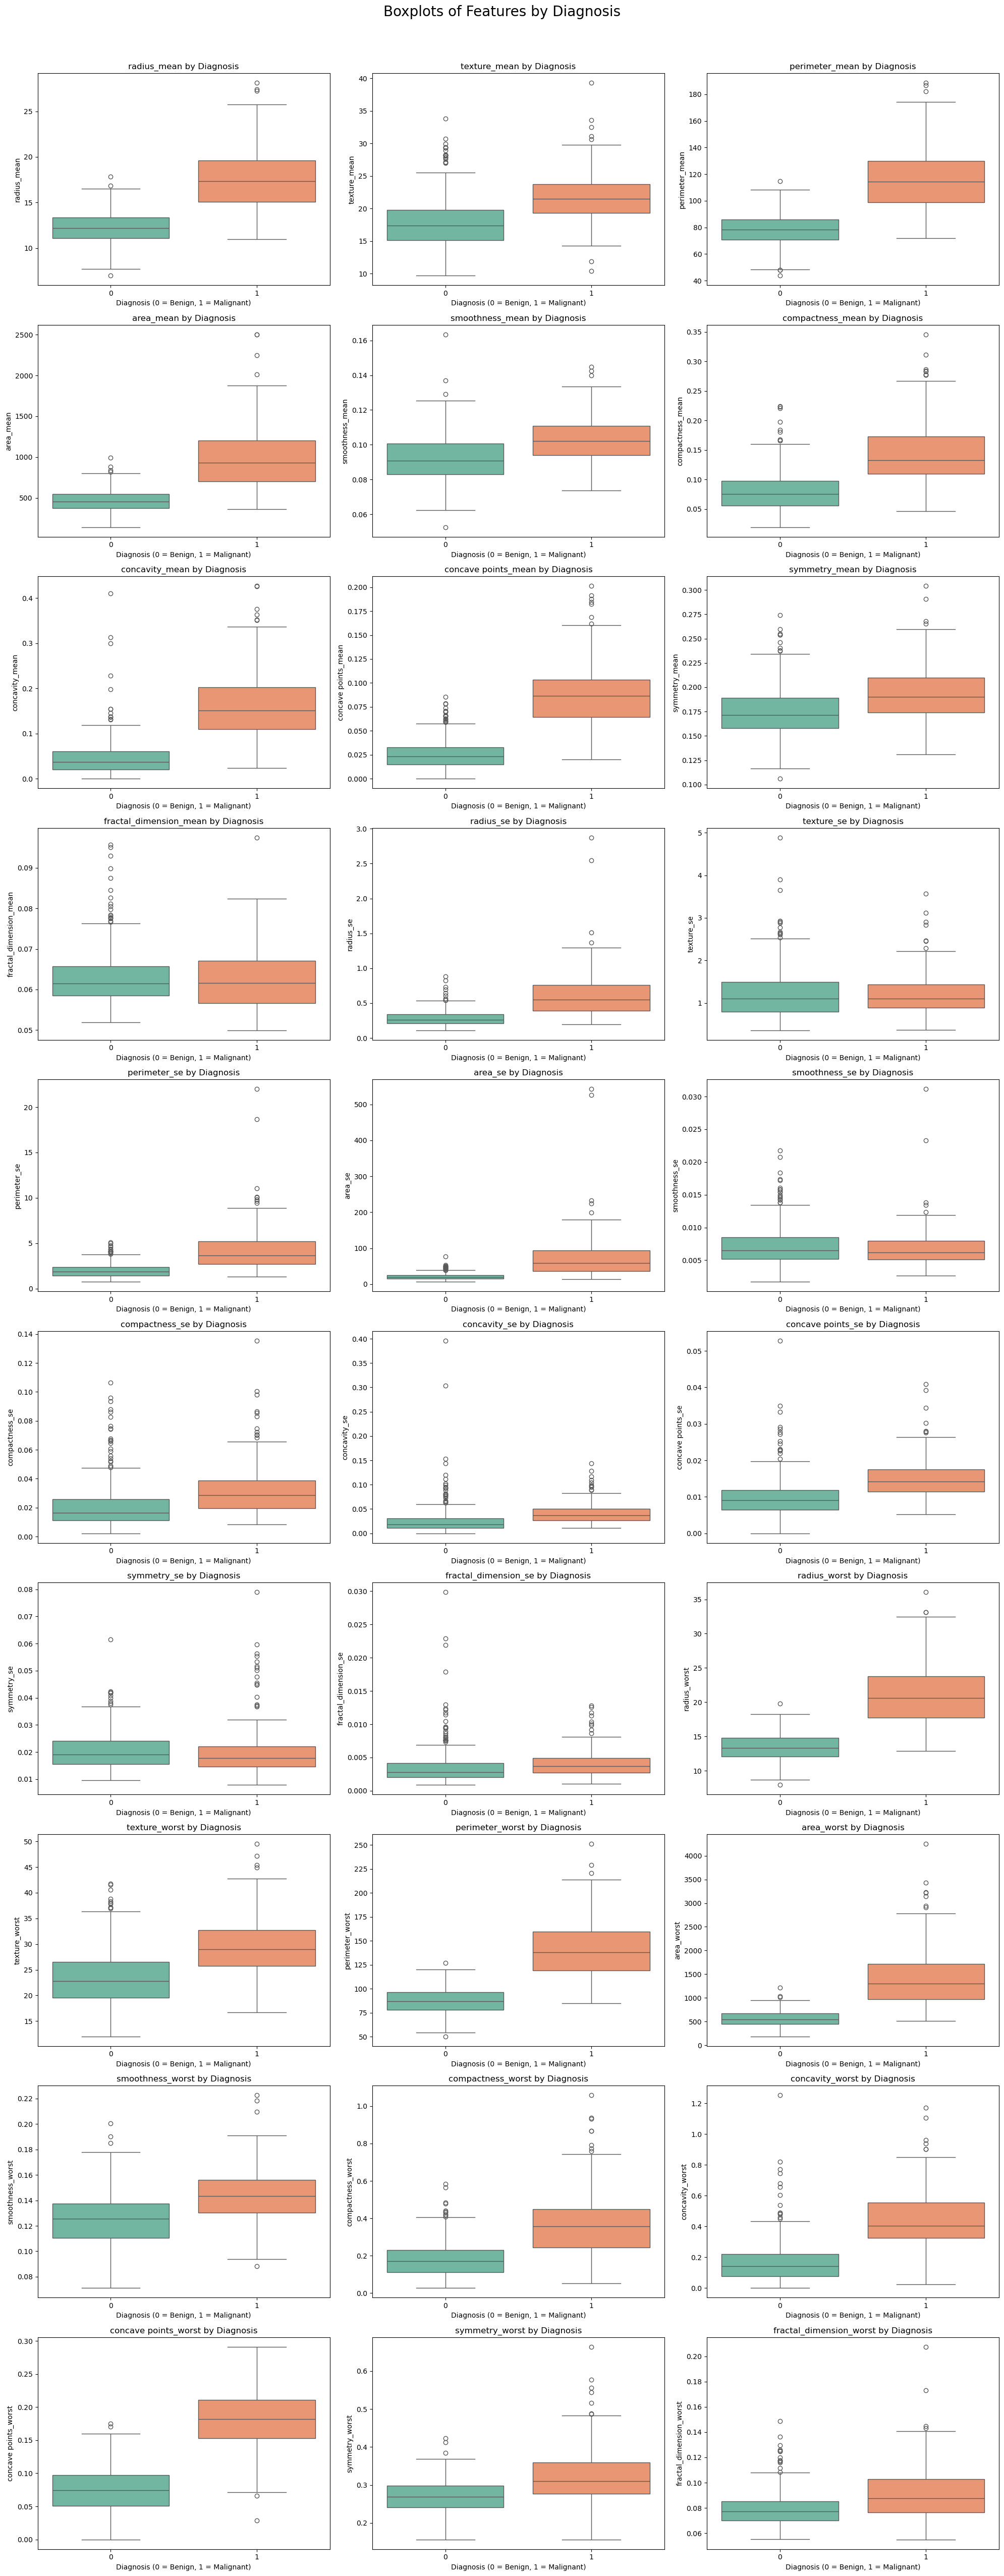

In [66]:
plt.figure(figsize=(20, 50))
for i, feature in enumerate(numeric_features):
    plt.subplot(10, 3, i + 1)
    sns.boxplot(x="diagnosis", y=feature, data=df, palette="Set2")
    plt.title(f"{feature} by Diagnosis")
    plt.xlabel("Diagnosis (0 = Benign, 1 = Malignant)")
    plt.tight_layout()

plt.suptitle("Boxplots of Features by Diagnosis", fontsize=20, y=1.02)
plt.show()


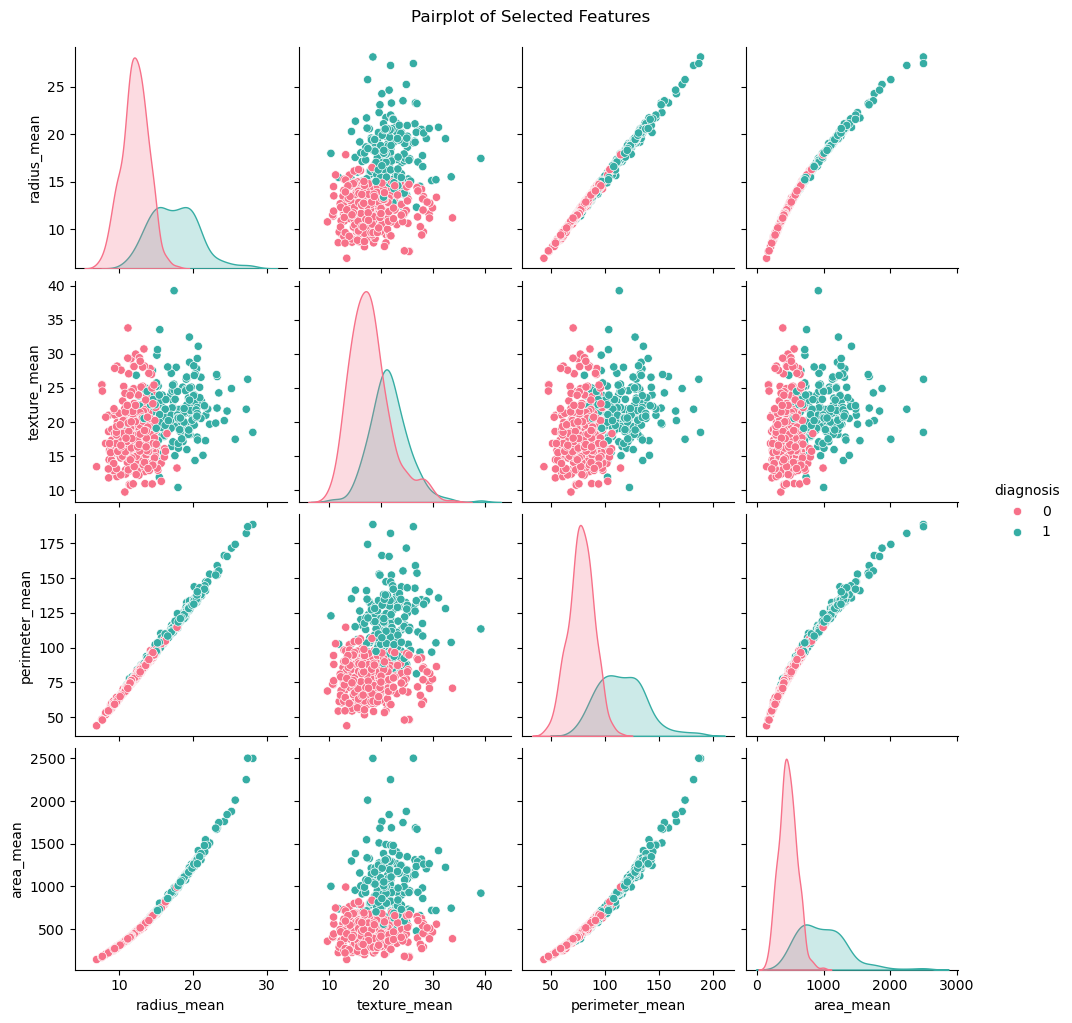

In [67]:
# Select a few features for clarity
features = ["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "diagnosis"]
pair_df = df[features]

# Plot
sns.pairplot(pair_df, hue="diagnosis", palette="husl")
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

*PLOTTING PCA*

PCA IS showing each dot is a patient, positioned using the most important patterns in the data.Colors show diagnosis (Malignant or Benign).
Helps us see how well the two classes are separated.

In [70]:
# Step 4: Standardize the feature values

X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


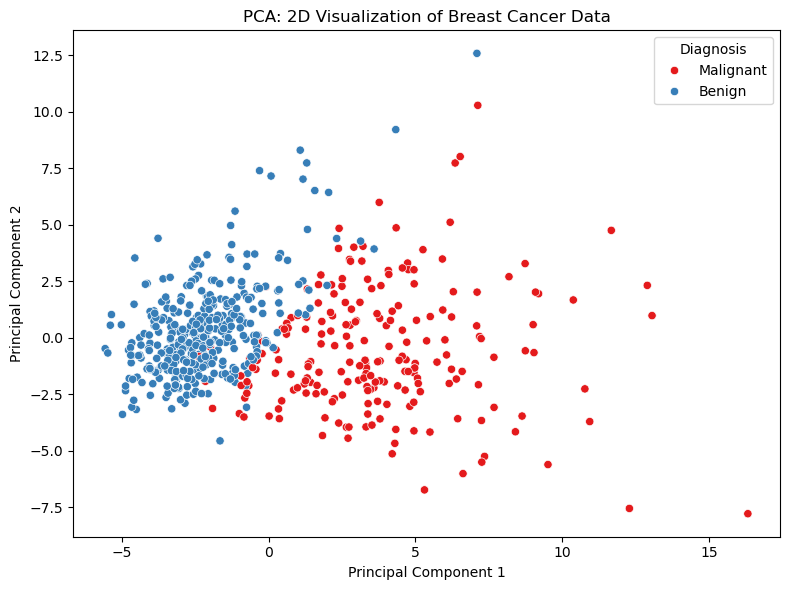

In [71]:

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Diagnosis'] = pd.Series(y).replace({1: 'Malignant', 0: 'Benign'})


# Plot the PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Diagnosis', palette='Set1')
plt.title("PCA: 2D Visualization of Breast Cancer Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Diagnosis')
plt.tight_layout()
plt.show()

## 5. Feature Scaling and Splitting

In [73]:
# Separate features and target
X = df.drop(columns=["diagnosis"]).values
y = df["diagnosis"].values

In [74]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [75]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 6. Graph Construction

In [77]:
def create_graph(data, labels, threshold=2.0):
    """Creates a graph based on feature similarity."""
    num_nodes = len(data)
    edge_index = []
    edge_attr = []
    
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            similarity = np.linalg.norm(data[i] - data[j])
            if similarity < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append(similarity)
                edge_attr.append(similarity)
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    x = torch.tensor(data, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [78]:
def build_similarity_graph(data: np.ndarray, labels: np.ndarray, threshold: float) -> nx.Graph:
    """
    Constructs an undirected graph where each node is a sample and edges
    connect pairs whose Euclidean distance < threshold.
    Node attribute 'label' holds the class (0/1).
    """
    G = nx.Graph()
    n = data.shape[0]
    
    # Add nodes with class labels
    for i in range(n):
        G.add_node(i, label=int(labels[i]))
        
    # Add edges for nodes within the distance threshold
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(data[i] - data[j])
            if dist < threshold:
                G.add_edge(i, j)
                
    return G


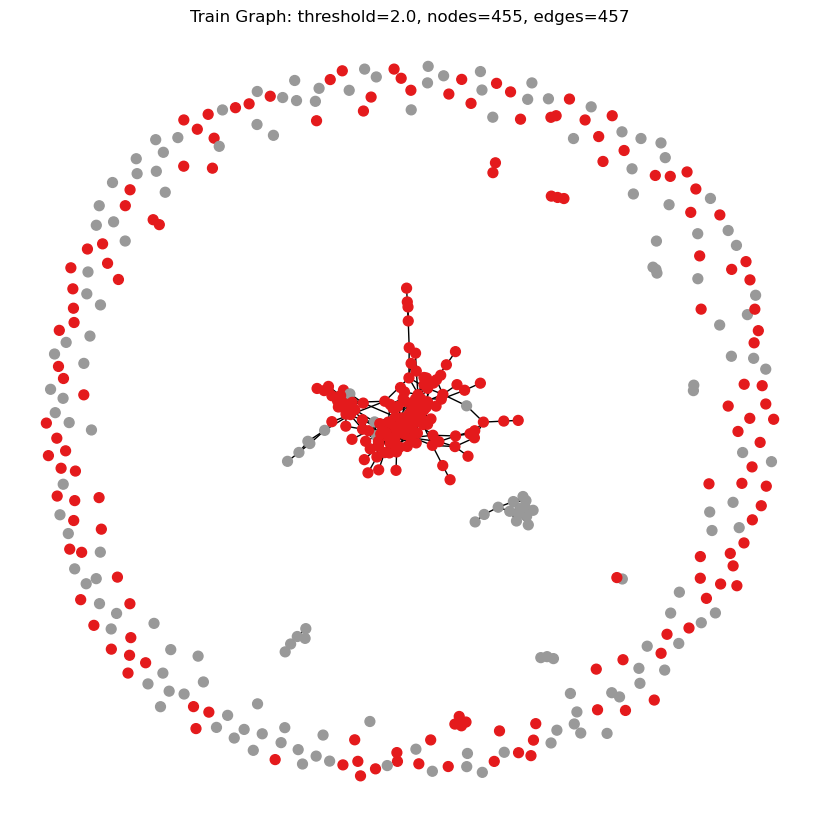

In [79]:
threshold = 2.0  # Tunable parameter
G_train = build_similarity_graph(X_train, y_train, threshold)

# Compute layout for visualization
pos = nx.spring_layout(G_train, seed=42)

# Color nodes by class label
node_colors = [G_train.nodes[i]['label'] for i in G_train.nodes()]

plt.figure(figsize=(8, 8))
nx.draw(
    G_train,
    pos,
    node_size=50,
    node_color=node_colors,
    cmap=plt.cm.Set1,
    with_labels=False
)
plt.title(f"Train Graph: threshold={threshold}, nodes={G_train.number_of_nodes()}, edges={G_train.number_of_edges()}")
plt.axis('off')
plt.show()


## 7. PyTorch Geometric Graph Creation

In [81]:
# Create PyTorch Geometric graphs
train_graph = create_graph(X_train, y_train)
test_graph = create_graph(X_test, y_test)

## 8. GAT Model Definition

In [83]:
class GATNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GATNet, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index, edge_attr=None):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)

## 9. Model Training and Evaluation

In [85]:
# Force CPU usage
device = torch.device("cpu")
model = GATNet(in_channels=X_train.shape[1], hidden_channels=16, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [86]:
# Move data to device
train_graph = train_graph.to(device)
test_graph = test_graph.to(device)

In [87]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_graph.x, train_graph.edge_index)
    loss = criterion(out, train_graph.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        return pred, out

In [88]:
# Training loop
epochs = 50
for epoch in range(epochs):
    loss = train()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

Epoch 1/50, Loss: 0.7440
Epoch 2/50, Loss: 0.5528
Epoch 3/50, Loss: 0.5390
Epoch 4/50, Loss: 0.4347
Epoch 5/50, Loss: 0.4455
Epoch 6/50, Loss: 0.4006
Epoch 7/50, Loss: 0.4352
Epoch 8/50, Loss: 0.4077
Epoch 9/50, Loss: 0.3986
Epoch 10/50, Loss: 0.3954
Epoch 11/50, Loss: 0.3947
Epoch 12/50, Loss: 0.4195
Epoch 13/50, Loss: 0.4573
Epoch 14/50, Loss: 0.3765
Epoch 15/50, Loss: 0.3738
Epoch 16/50, Loss: 0.3796
Epoch 17/50, Loss: 0.3817
Epoch 18/50, Loss: 0.3726
Epoch 19/50, Loss: 0.3687
Epoch 20/50, Loss: 0.4060
Epoch 21/50, Loss: 0.3803
Epoch 22/50, Loss: 0.3859
Epoch 23/50, Loss: 0.3716
Epoch 24/50, Loss: 0.3768
Epoch 25/50, Loss: 0.3674
Epoch 26/50, Loss: 0.3701
Epoch 27/50, Loss: 0.3684
Epoch 28/50, Loss: 0.3962
Epoch 29/50, Loss: 0.3435
Epoch 30/50, Loss: 0.3875
Epoch 31/50, Loss: 0.4155
Epoch 32/50, Loss: 0.3444
Epoch 33/50, Loss: 0.3785
Epoch 34/50, Loss: 0.3520
Epoch 35/50, Loss: 0.3568
Epoch 36/50, Loss: 0.4101
Epoch 37/50, Loss: 0.3838
Epoch 38/50, Loss: 0.3818
Epoch 39/50, Loss: 0.

## 10. Model Performance

In [90]:
# Evaluate the model
test_pred, test_out = evaluate(test_graph)
print("Classification Report:")
print(classification_report(y_test, test_pred.cpu().numpy()))
print(f"ROC-AUC Score: {roc_auc_score(y_test, test_out[:, 1].cpu().numpy()):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        72
           1       0.95      0.95      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

ROC-AUC Score: 0.9950
